In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np
import pickle
import os
from PIL import Image

from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import h5py

from time import time

################## LOGGING-BEGIN #########################
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
################## LOGGING-END ###########################

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# From Assignment 2 PyTorch Notebook
USE_GPU = True

dtype = torch.float32 # we will be using float throughout

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
# Adapted from https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

HEIGHT_INDEX = 200
WIDTH_INDEX = 200

IMG_HEIGHT = 64
IMG_WIDTH = 64

NUM_CHANNELS_IN = 2
NUM_CHANNELS_OUT = 1

TRAIN_FILES = 10
VAL_FILES = 2
TEST_FILES = 3
YEARS_PER_FILE = 10
IMGS_PER_YEAR = 365

TRAIN_MODE = 0
VAL_MODE = 1
TEST_MODE = 2

class SR_Dataset(data.Dataset):
    """
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    base_folder = 'sr_data'
    elevation_file = 'dem.pkl'
    
    train_list = np.array([
        '1950s.hdf5',
        '1960s.hdf5',
        '1970s.hdf5',
        '1980s.hdf5',
        '1990s.hdf5',
        '2000s.hdf5',
        '2010s.hdf5',
        '2020s.hdf5',
        '2030s.hdf5',
        '2040s.hdf5'
    ])
    
    val_list = np.array([
        '2050s.hdf5',
        '2060s.hdf5'
    ])

    test_list = np.array([
        '2070s.hdf5',
        '2080s.hdf5',
        '2090s.hdf5'
    ])

    def __init__(self, root, train=TRAIN_MODE):
        
        self.root = os.path.expanduser(root)
        self.train = train  # training set or val set or test set
        
        # load elevation data
        fo_in = open(os.path.join(self.root, self.elevation_file), 'rb')
        self.elevation = pickle.load(fo_in)
        fo_in.close()
        self.elevation = self.elevation[HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]
        elev_mean = np.mean(self.elevation)
        elev_var = np.var(self.elevation)
        self.elevation = (self.elevation - elev_mean) / np.sqrt(elev_var)
        h,w=self.elevation.shape
        self.elevation = self.elevation.reshape((1,h,w))

    in_mean = np.array([1.9028055e-05])
    in_var = np.array([1.5503707e-09])
    out_mean = np.array([1.902273e-05])
    out_var = np.array([2.3926674e-09])
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (low_res, high_res)
        """
        t1 = time()
        file_idx = index // (YEARS_PER_FILE * IMGS_PER_YEAR)
        img_in_file = index % (YEARS_PER_FILE * IMGS_PER_YEAR)
        year_idx = img_in_file // IMGS_PER_YEAR
        idx_in_year = img_in_file % IMGS_PER_YEAR
        
        f = None
        if self.train == TRAIN_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.train_list[file_idx]), 'r')
        elif self.train == VAL_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.val_list[file_idx]), 'r')
        elif self.train == TEST_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.test_list[file_idx]), 'r')
        
        yr = list(f.keys())[year_idx]
        pr =  f[yr]['pr'][idx_in_year]
        f.close()
        high_res = np.flip(pr[np.newaxis,:,:], axis=1)
        high_res = high_res[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]

        # get the input LR image from output HR image
        c,h1,w1 = high_res.shape
        blurred = np.zeros_like(high_res)
        for i in range(c):
            blurred[i,:,:] = gaussian_filter(high_res[i,:,:], 0.55)
        half_res = blurred[:, ::2, ::2]
        c,h2,w2 = half_res.shape
        x = np.arange(h2)
        y = np.arange(w2)
        xnew = np.arange(0, h2, h2/h1)
        ynew = np.arange(0, w2, w2/w1)
        low_res = np.zeros_like(high_res)
        for i in range(c):
            f = RectBivariateSpline(x, y, half_res[i, :, :])
            low_res[i, :, :] = f(xnew, ynew)
            
        low_res =  (low_res -  self.in_mean[:,np.newaxis,np.newaxis])  / np.sqrt(self.in_var[:,np.newaxis,np.newaxis])
        high_res = (high_res - self.out_mean[:,np.newaxis,np.newaxis]) / np.sqrt(self.out_var[:,np.newaxis,np.newaxis])
        
        low_res = np.concatenate((low_res, self.elevation))
        
        # Set the range of values of the training data from 0 to 1, and high res from -1 to 1, as they do in Ledig
        low_res -= np.amin(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        low_res /= np.amax(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        
        
        high_min = np.amin(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        high_max = np.amax(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        is_nan = np.int(high_min[0] == high_max[0])
        eps = 1e-9
        high_res = (high_res - high_min) / ((high_max - high_min + is_nan*eps) / 2) - 1
        
        
        if np.isnan(high_res).any():
            print("CREATED A NAN")
            print("high_min: ", high_min)
            print("high_max: ", high_max)
            print("year index: ", year_idx)
            print("idx in year: ", idx_in_year)
            print("pr contain nans? ", np.isnan(pr).any())
            print("tas contains nans? ", np.isnan(tas).any())
        
        low_res = torch.from_numpy(low_res)
        high_res = torch.from_numpy(high_res)
        
        #print(time()-t1)
        return low_res, high_res

    def __len__(self):
        print('not useful, fake!!!')
        return 0

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [4]:
data_directory = '.'

batch_size = 200

sr_train = SR_Dataset(data_directory, train=TRAIN_MODE)
loader_train = DataLoader(sr_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(TRAIN_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

sr_val = SR_Dataset(data_directory, train=VAL_MODE)
loader_val = DataLoader(sr_val, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(VAL_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

sr_test = SR_Dataset(data_directory, train=TEST_MODE)
loader_test = DataLoader(sr_test, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(TEST_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

In [5]:
# used https://github.com/togheppi/pytorch-super-resolution-model-collection/blob/master/srcnn.py to get basic idea
class SRCNN(nn.Module):
    def __init__(self, num_channels_in, num_channels_out, hidden_channels):
        super().__init__()
        
        self.layers = nn.Sequential( # this is the original SRCNN from Dong et al. 2015
            nn.ReplicationPad2d(4),
            #nn.Conv2d(num_channels_in, hidden_channels, 9, padding=4),
            nn.Conv2d(num_channels_in, hidden_channels, 9, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels//2, 1, padding=0),
            nn.ReLU(),
            nn.ReplicationPad2d(2),
            #nn.Conv2d(hidden_channels//2, num_channels_out, 5, padding=2)
            nn.Conv2d(hidden_channels//2, num_channels_out, 5, padding=0)
        )
        
    def forward(self, x):
        return self.layers(x)

In [6]:
def test_SRCNN():
    x = torch.zeros((64, NUM_CHANNELS_IN, IMG_HEIGHT, IMG_WIDTH), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = SRCNN(NUM_CHANNELS_IN, NUM_CHANNELS_OUT, 16)
    scores = model(x)
    print(scores.size())
test_SRCNN()

torch.Size([64, 1, 64, 64])


In [7]:
def plot_epoch(x, y_pred, y):
    plt.figure(figsize=(16,12))
    plt.subplot(1,3,1)
    plt.imshow(x[0,0,:,:].cpu().detach().numpy())
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0,0,:,:].cpu().detach().numpy())
    plt.subplot(1,3,3)
    plt.imshow(y[0,0,:,:].cpu().detach().numpy())
    plt.show()

In [8]:
def plot_loss(train_loss, rmse_precip):
    tcount = np.count_nonzero(train_loss)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(range(tcount), train_loss[range(tcount)])
    plt.title("SRCNN Loss")
    plt.xlabel("Iteration")
    
    plt.subplot(1,2,2)
    plt.plot(range(tcount), rmse_precip[range(tcount)])
    plt.title("SRCNN Precipitation Loss")
    plt.xlabel("Iteration")
    plt.show()

In [25]:
################## LOGGING-BEGIN #########################
# how often to log images
save_img_every = 500
val_every = 200
print_every = 200
exp_name = 'experiments/train_SRCNN_preciponly_lr1e-4_06_07_20epoch'
writer = SummaryWriter(exp_name)
################## LOGGING-END ###########################

In [26]:
def train_it(optimizer, model, num_epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print("Expected num iters: ", len(loader_train)*epochs)
    train_loss = np.zeros(len(loader_train)*num_epochs+1)
    rmse_precip = np.zeros(len(loader_train)*num_epochs+1)
    iter_count = 0
    best_rmse_precip_val = 10000
    tic = time()
    for e in range(num_epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            y_predicted = model(x)
            loss_func = nn.MSELoss()
            loss = loss_func(y_predicted, y)
            train_loss[iter_count] = loss.item()
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            rmse_precip[iter_count] = torch.sqrt(torch.mean((y_predicted[:, 0, :, :] - y[:, 0, :, :]).pow(2)))

            if iter_count % val_every == 0:
                loss_total = 0 
                rmse_precip_val = check_accuracy(loader_val, model)
                if rmse_precip_val < best_rmse_precip_val:
                    torch.save(model.cpu().state_dict(), 'training_SRCNN_06_07_preciponly_best_precip.pt')
                    model = model.to(device=device)
                    best_rmse_precip_val = rmse_precip_val
                    
                writer.add_scalars('Both precip RMSE',
                                      {'Train': rmse_precip[iter_count],
                                      'Val': rmse_precip_val}, iter_count)
            
            if iter_count % print_every == 0:
                print('Epoch %d, Iteration %d, loss=%.4f, RMSEp=%.4f' % (e, t, loss.item(), 
                                                                                     rmse_precip[iter_count]))
                plot_epoch(x, y_predicted, y)
                plot_loss(train_loss, rmse_precip)
                
            if iter_count % save_img_every == 0:
                # precip
                input_precip_grid = vutils.make_grid(x[0, 0, :, :])
                writer.add_image('Input precipitation', input_precip_grid, iter_count)
                output_precip_grid = vutils.make_grid(y_predicted[0, 0, :, :])
                writer.add_image('Output precipitation', output_precip_grid, iter_count)
                true_precip_grid = vutils.make_grid(y[0, 0, :, :])
                writer.add_image('True precipitation', true_precip_grid, iter_count)
            
            iter_count += 1
                
            del x, y, loss
        torch.save(model.cpu().state_dict(), 'training_SRCNN_06_07_preciponly_checkpoint.pt')
        model = model.to(device=device)
        print('Epoch ', e, ' complete!')

In [27]:
def check_baseline_accuracy(loader):
    #if loader.dataset.train == TRAIN_MODE:
    #    print('Checking accuracy on train set')
    #elif loader.dataset.train == VAL_MODE:
    #    print('Checking accuracy on validation set')
    #elif loader.dataset.train == TEST_MODE:
    #    print('Checking accuracy on test set')
    count, rmse_precip_x = 0, 0, 
    with torch.no_grad():
        for x, y in loader:
            y = y.to(device=device, dtype=dtype)
            
            # Normalize x to be in -1 to 1 for purpose of comparing with high res data in same range
            # Turn it into a numpy array
            x_np = x.numpy()
            x_min = np.amin(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            x_max = np.amax(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            is_nan = np.int((x_min == x_max).any())
            eps = 1e-9
            x_norm_np = (x_np - x_min) / ((x_max - x_min + is_nan*eps) / 2) - 1
            
            x_norm = torch.from_numpy(x_norm_np)
            x_norm = x_norm.to(device=device, dtype=dtype)
            
            rmse_precip_x += torch.sqrt(torch.mean((x_norm[:,0,:,:]-y[:,0,:,:]).pow(2)))
            count += 1
            
        rmse_precip_x /= count
        print('RMSEs: \tInput precip: %.3f\n' % 
              (rmse_precip_x))
        
    return rmse_precip_x

def check_accuracy(loader, model):
    model = model.to(device=device)
    model.eval() # set model to evaluation mode
    count, rmse_precip = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            y_predicted = model(x)
            rmse_precip += torch.sqrt(torch.mean((y_predicted[:,0,:,:]-y[:,0,:,:]).pow(2)))
            count += 1
            
        rmse_precip /= count
        print('RMSEs: \tOutput precip: %.3f\n' % 
              (rmse_precip))

    return rmse_precip

Expected num iters:  3660
RMSEs: 	Output precip: 0.889

Epoch 0, Iteration 0, loss=0.7973, RMSEp=0.8929


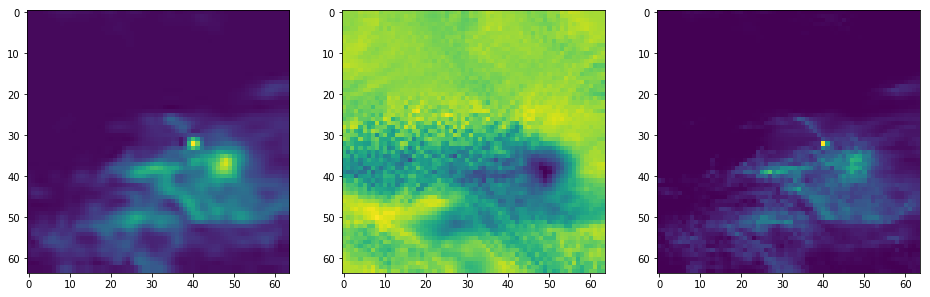

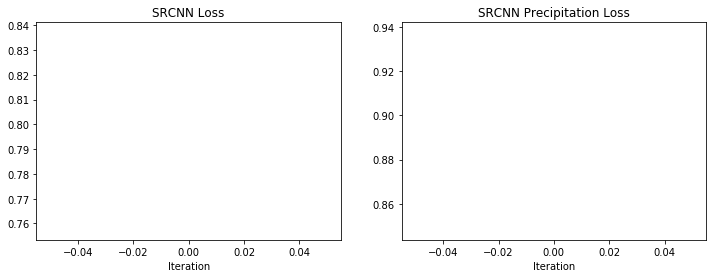

Epoch  0  complete!
RMSEs: 	Output precip: 0.135

Epoch 1, Iteration 17, loss=0.0178, RMSEp=0.1333


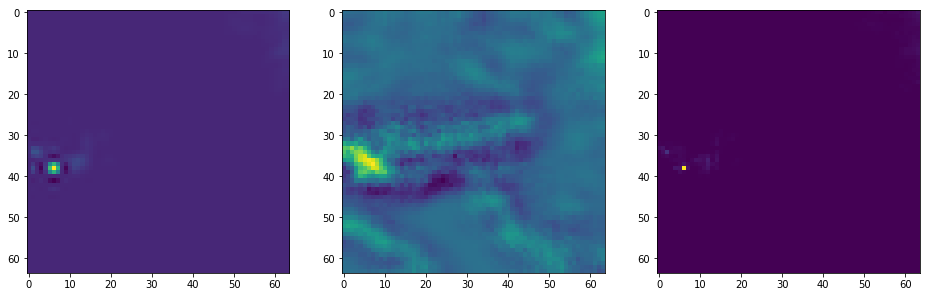

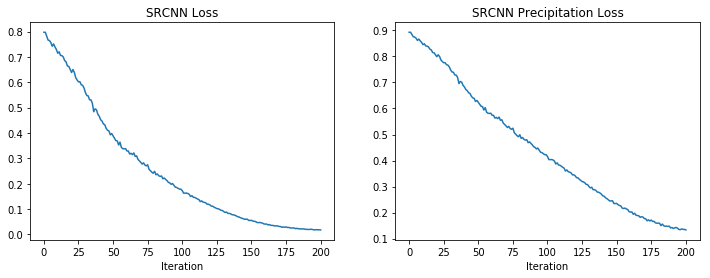

Epoch  1  complete!
RMSEs: 	Output precip: 0.108

Epoch 2, Iteration 34, loss=0.0107, RMSEp=0.1034


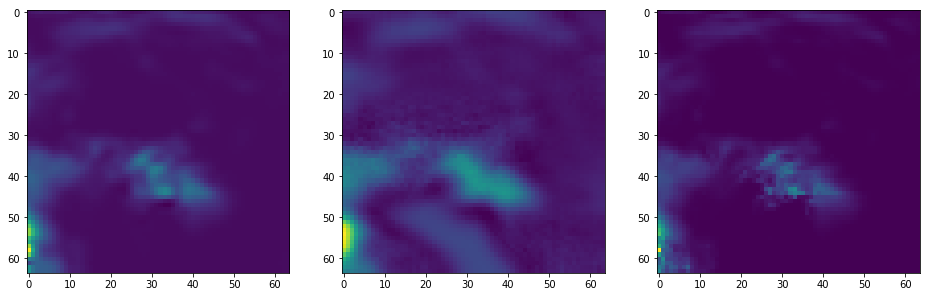

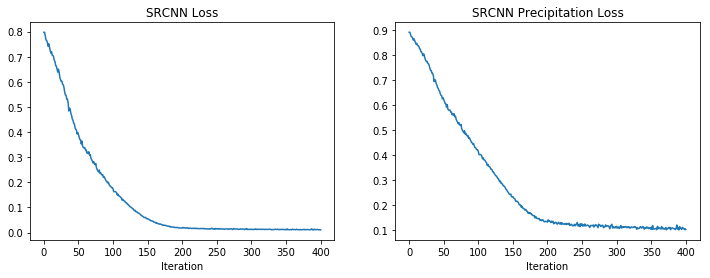

Epoch  2  complete!
RMSEs: 	Output precip: 0.101

Epoch 3, Iteration 51, loss=0.0123, RMSEp=0.1111


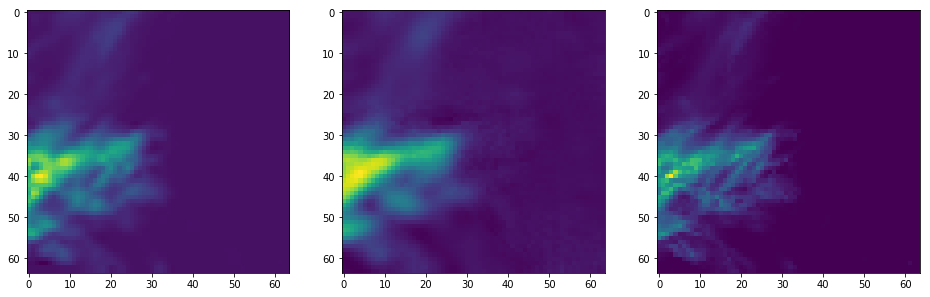

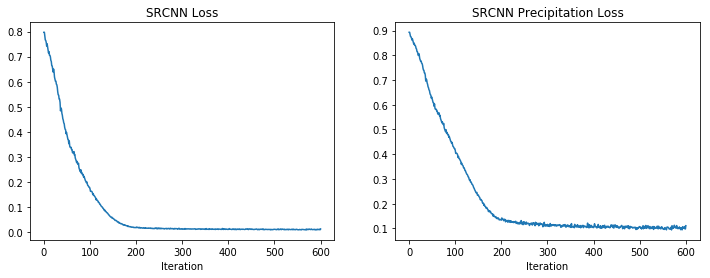

Epoch  3  complete!
RMSEs: 	Output precip: 0.098

Epoch 4, Iteration 68, loss=0.0092, RMSEp=0.0960


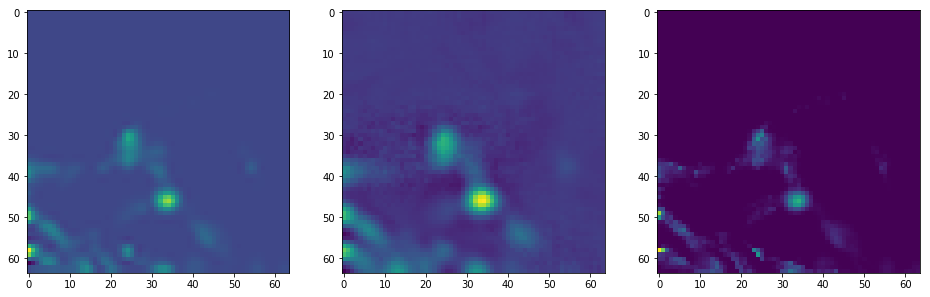

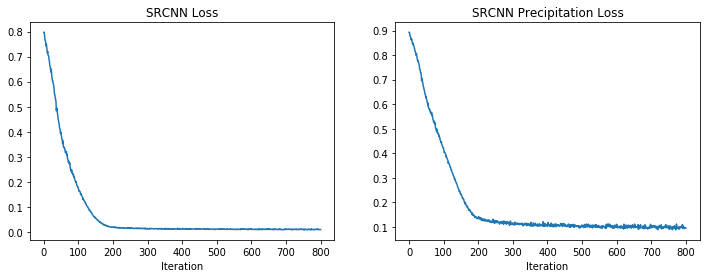

Epoch  4  complete!
RMSEs: 	Output precip: 0.097

Epoch 5, Iteration 85, loss=0.0096, RMSEp=0.0978


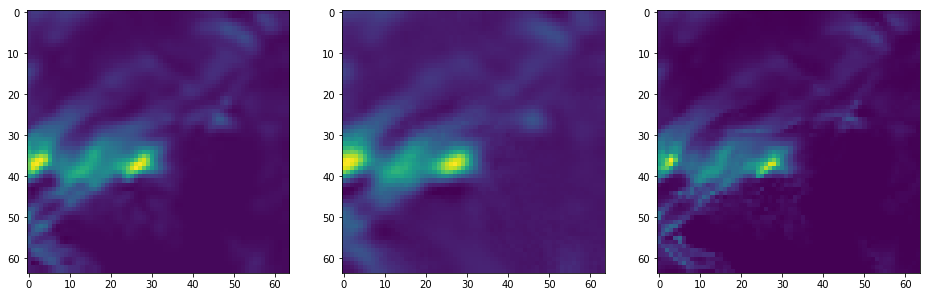

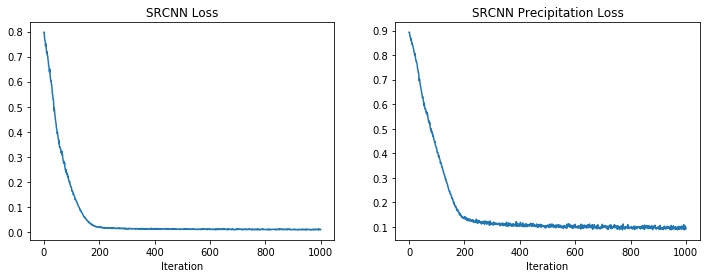

Epoch  5  complete!
RMSEs: 	Output precip: 0.094

Epoch 6, Iteration 102, loss=0.0080, RMSEp=0.0896


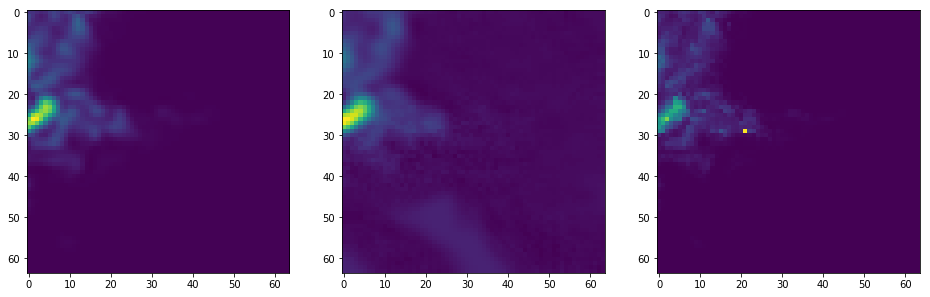

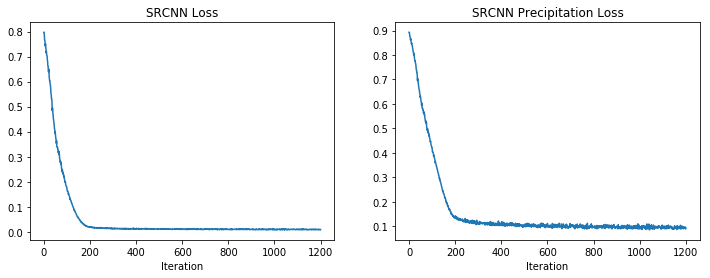

Epoch  6  complete!
RMSEs: 	Output precip: 0.092

Epoch 7, Iteration 119, loss=0.0090, RMSEp=0.0950


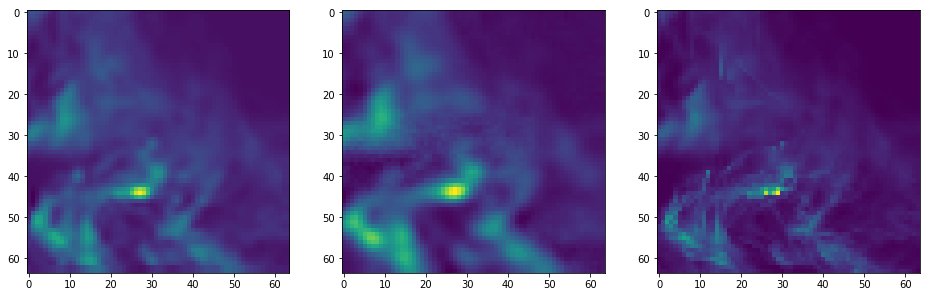

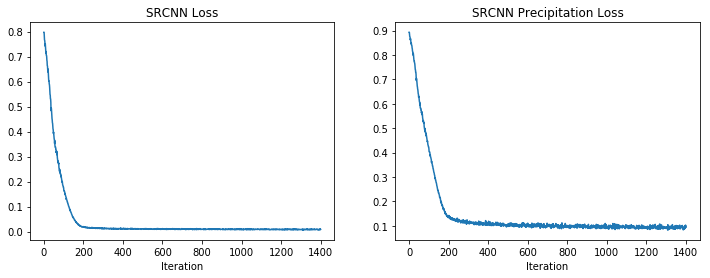

Epoch  7  complete!
RMSEs: 	Output precip: 0.091

Epoch 8, Iteration 136, loss=0.0068, RMSEp=0.0822


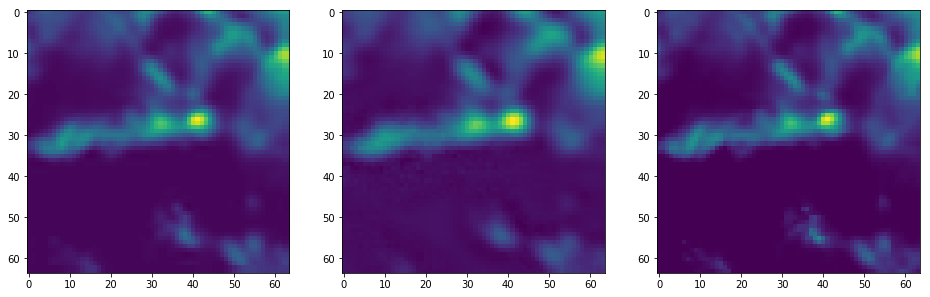

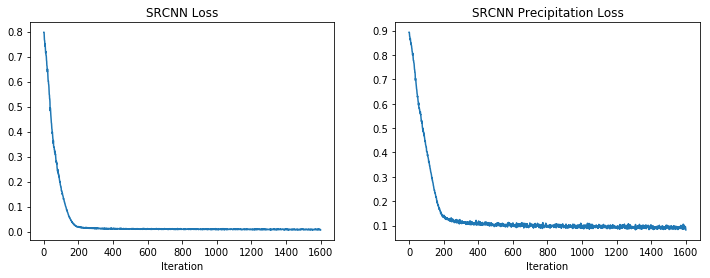

Epoch  8  complete!
RMSEs: 	Output precip: 0.091

Epoch 9, Iteration 153, loss=0.0079, RMSEp=0.0887


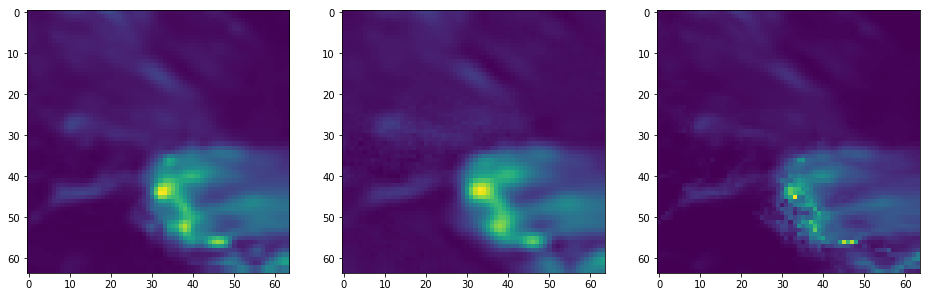

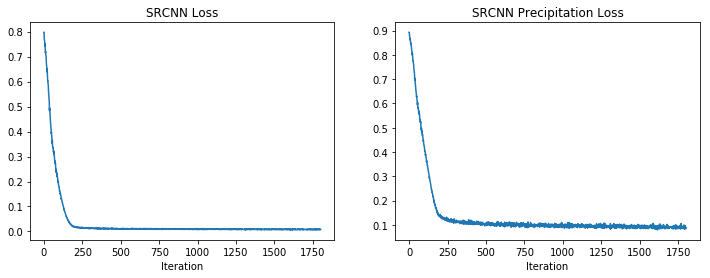

Epoch  9  complete!
RMSEs: 	Output precip: 0.090

Epoch 10, Iteration 170, loss=0.0078, RMSEp=0.0885


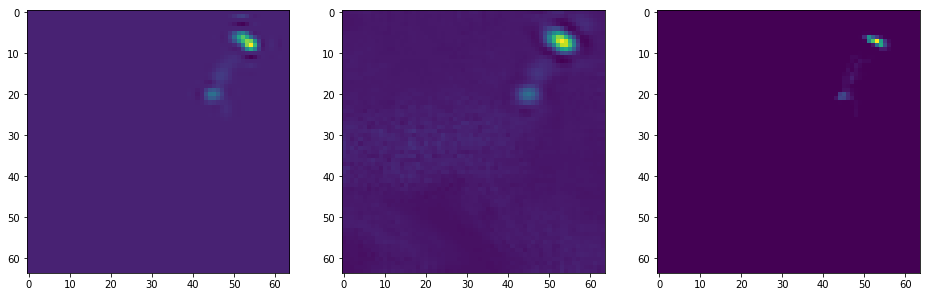

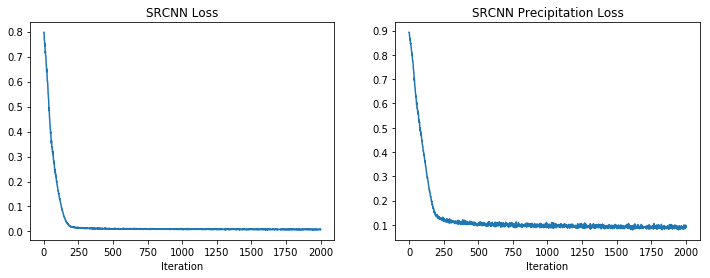

Epoch  10  complete!
Epoch  11  complete!
RMSEs: 	Output precip: 0.088

Epoch 12, Iteration 4, loss=0.0086, RMSEp=0.0925


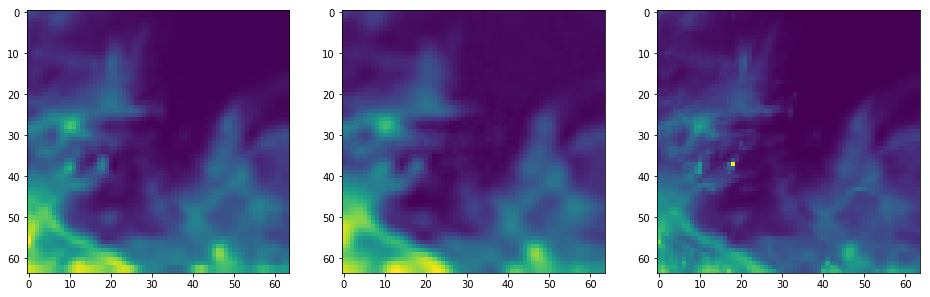

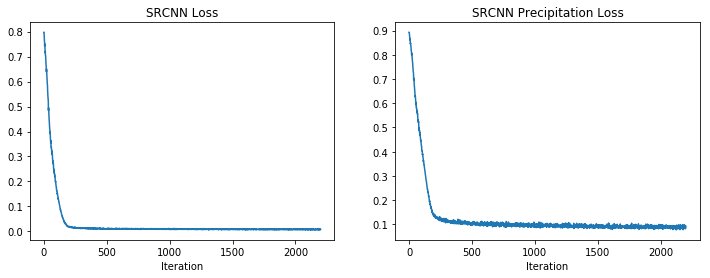

Epoch  12  complete!
RMSEs: 	Output precip: 0.088

Epoch 13, Iteration 21, loss=0.0075, RMSEp=0.0868


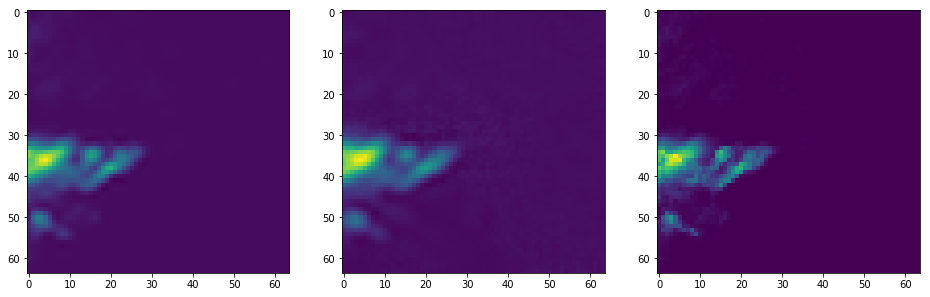

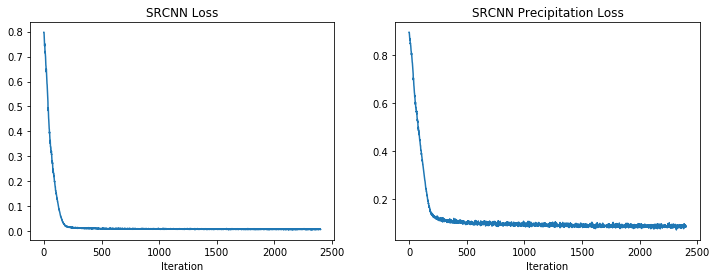

Epoch  13  complete!
RMSEs: 	Output precip: 0.087

Epoch 14, Iteration 38, loss=0.0073, RMSEp=0.0855


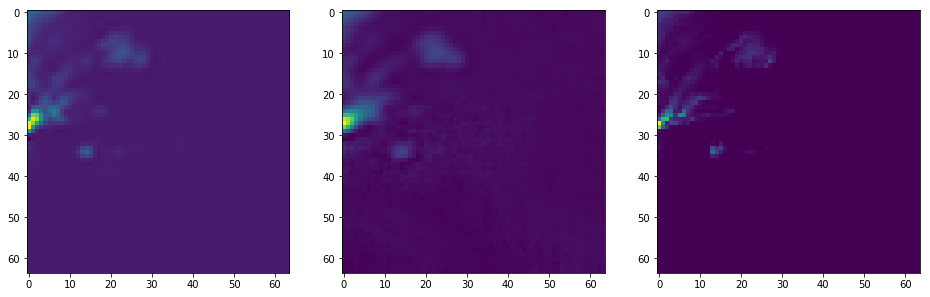

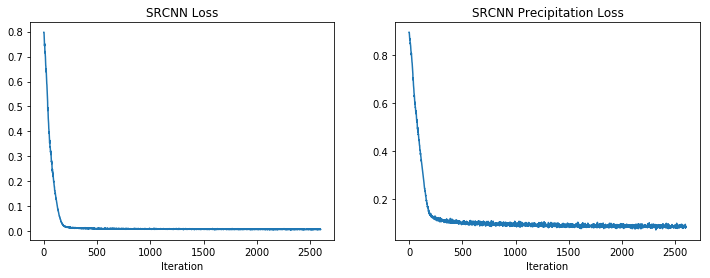

Epoch  14  complete!
RMSEs: 	Output precip: 0.087

Epoch 15, Iteration 55, loss=0.0074, RMSEp=0.0858


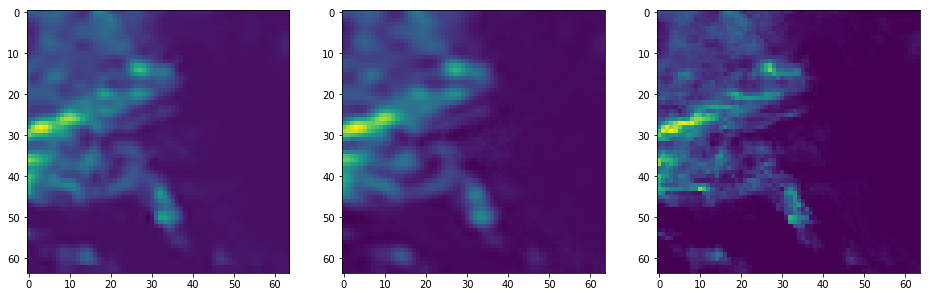

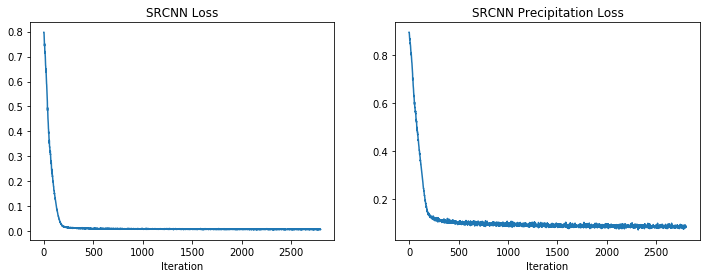

Epoch  15  complete!
RMSEs: 	Output precip: 0.086

Epoch 16, Iteration 72, loss=0.0072, RMSEp=0.0847


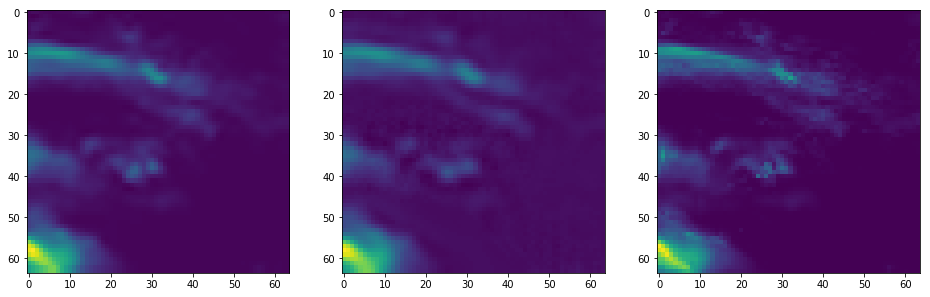

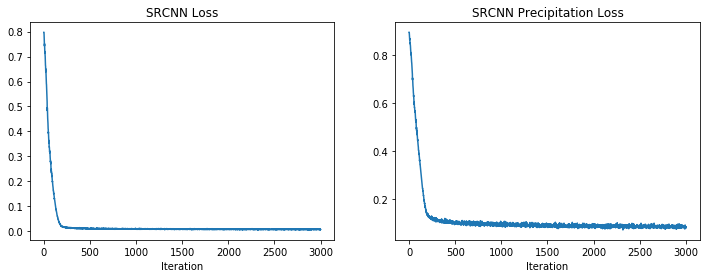

Epoch  16  complete!
RMSEs: 	Output precip: 0.085

Epoch 17, Iteration 89, loss=0.0080, RMSEp=0.0893


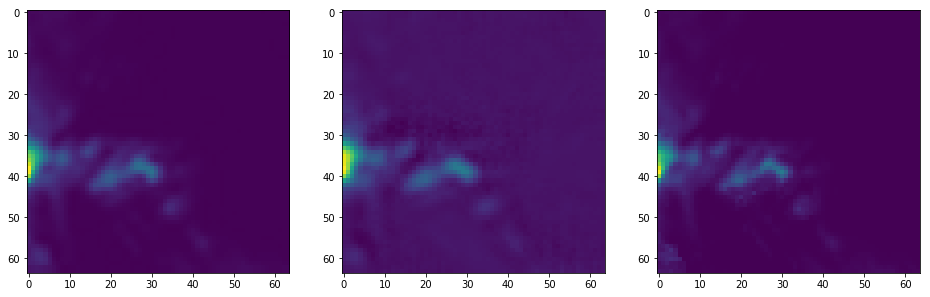

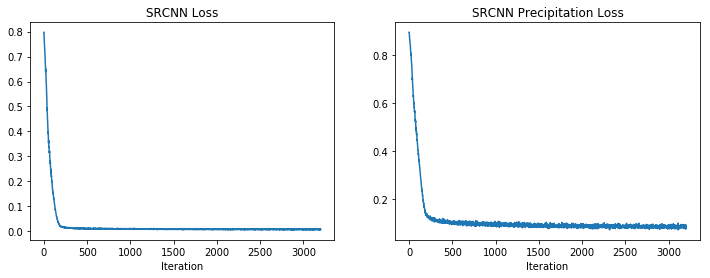

Epoch  17  complete!
RMSEs: 	Output precip: 0.085

Epoch 18, Iteration 106, loss=0.0072, RMSEp=0.0851


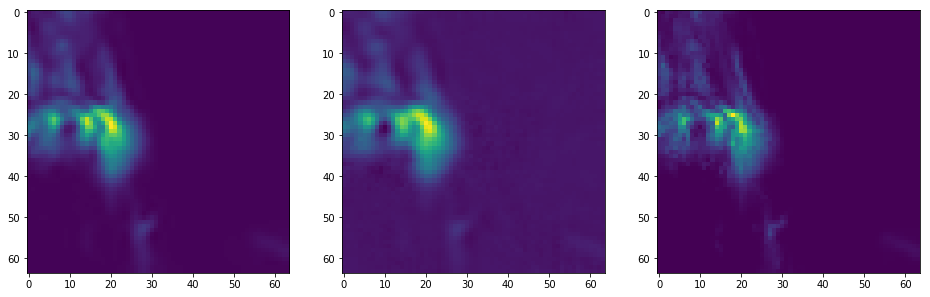

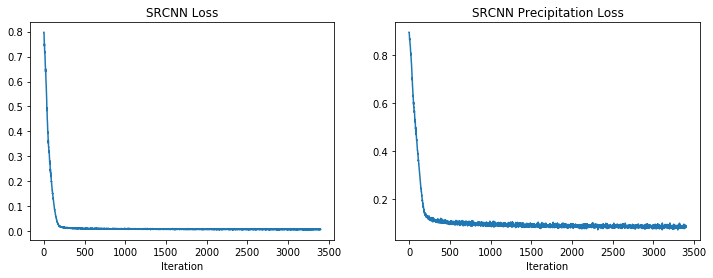

Epoch  18  complete!
RMSEs: 	Output precip: 0.085

Epoch 19, Iteration 123, loss=0.0066, RMSEp=0.0814


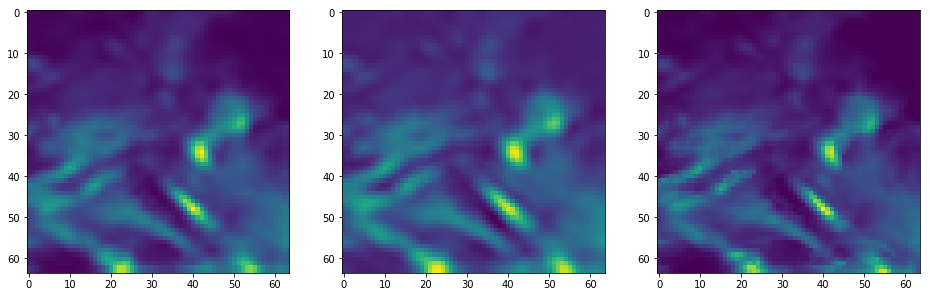

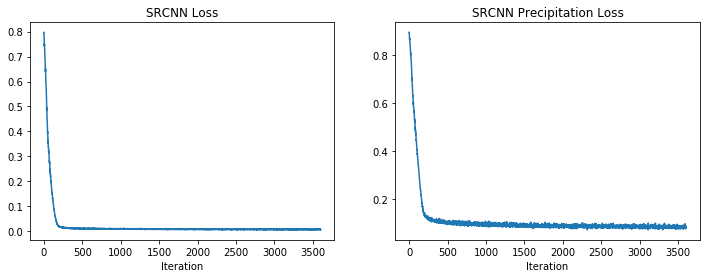

Epoch  19  complete!


In [28]:
learning_rate = 1e-4

epochs = 20

#check_baseline_accuracy(loader_val)
model = SRCNN(NUM_CHANNELS_IN, NUM_CHANNELS_OUT, 64)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_it(optimizer, model, num_epochs=epochs)

# Performance Metrics

In [29]:
model = SRCNN(NUM_CHANNELS_IN, NUM_CHANNELS_OUT, 64)
model.load_state_dict(torch.load('training_SRCNN_06_07_preciponly_best_precip.pt'))

In [30]:
batch_size = 1000

data_directory = '.'

sr_test = SR_Dataset(data_directory, train=TEST_MODE)
loader_test = DataLoader(sr_test, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(TEST_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

In [31]:
#check_baseline_accuracy(loader_test)
check_accuracy(loader_test, model)

RMSEs: 	Output precip: 0.085



tensor(1.00000e-02 *
       8.4683, device='cuda:0')

In [32]:
def rmse_pixel(gen, target):
    return np.sqrt(np.mean(np.square(gen - target), axis = 0))

In [33]:
# y, y_pred: (N, C, H, W)
def get_extremes(y, y_pred, quantiles, metric_fn):
    output = np.zeros((2, len(quantiles), 2)) # channel, quantile, [mean/variance]
    for q_index, q in enumerate(quantiles):
        y_precip = y[:, 0, :, :]
        y_pred_precip = y_pred[:, 0, :, :]
        
        H = y.shape[2]
        W = y.shape[3]
        # [precip|temp]_indices are (num_values*H*W, 3) arrays, where num_values is the number of values
        # above this percentile, and the 3 columns correspodn to the three coordinates (see the for loops)
        # below
        precip_indices = np.array(np.where(y_precip > np.percentile(a = y_precip, q = q, axis = 0))).T
        num_values = int(precip_indices.shape[0] / (H * W)) + 1
        y_precip_extreme = np.zeros((num_values, H, W))
        y_pred_precip_extreme = np.zeros((num_values, H, W))
#         if num_values <= 2: continue
        # coordinates aren't in order of pixel, so keep track of how many values we've layered
        # for each pixel so far
        counters = np.zeros((H, W), dtype = int)
        for i, j, k in precip_indices:
            y_precip_extreme[counters[j, k], j, k] = y_precip[i, j, k]
            y_pred_precip_extreme[counters[j, k], j, k] = y_pred_precip[i, j, k]
            counters[j, k] += 1

        metric_precip = metric_fn(y_precip_extreme, y_pred_precip_extreme)
        output[0, q_index, 0] = np.mean(metric_precip)
        output[0, q_index, 1] = np.var(metric_precip)
    return output

In [34]:
# G is generic for any image-generating model; could be SRCNN too
def get_metrics(loader, G):
    G = G.to(device=device)
    G.eval() # set model to evaluation mode
    
    # initialize metrics
    final_rmse = None
    extreme_quantiles = [i / 10 for i in range(900, 1000, 5)]
    extreme_metrics = [] # list will be populated with metrics from each batch
    count = 0
    
    # calculate all metrics in one pass through val set
    with torch.no_grad():
        count = 0
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            y_pred = G(x)
            y = y.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            if final_rmse is not None:
                final_rmse += rmse_pixel(y, y_pred)
            else:
                final_rmse = rmse_pixel(y, y_pred)
            extreme_metrics.append(get_extremes(y, y_pred, extreme_quantiles, rmse_pixel))
            count += 1
            print('Done with batch %d.' % count)
        final_rmse /= count
        # num_batches, channel, quantile, [mean|variance]
        extreme_metrics = np.array(extreme_metrics)
        # channel, quantile, [mean|variance]
        extreme_metrics = np.mean(extreme_metrics, axis = 0)
    return final_rmse, extreme_metrics

In [35]:
final_rmse, extreme_metrics = get_metrics(loader_test, model)

Done with batch 1.
Done with batch 2.
Done with batch 3.
Done with batch 4.
Done with batch 5.
Done with batch 6.
Done with batch 7.
Done with batch 8.
Done with batch 9.
Done with batch 10.
Done with batch 11.


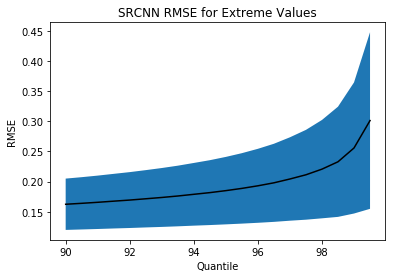

In [36]:
extreme_quantiles = [i / 10 for i in range(900, 1000, 5)]
# quantile, [mean|variance]
extreme_metrics_precip = extreme_metrics[0, :, :]
plt.fill_between(
    extreme_quantiles, 
    extreme_metrics_precip[:, 0] - np.sqrt(extreme_metrics_precip[:, 1]),
    extreme_metrics_precip[:, 0] + np.sqrt(extreme_metrics_precip[:, 1]),
)
plt.plot(extreme_quantiles, extreme_metrics_precip[:, 0], 'k')
plt.xlabel('Quantile')
plt.ylabel('RMSE')
plt.title('SRCNN RMSE for Extreme Values')
plt.show()

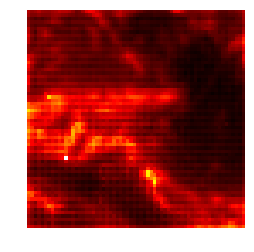

In [37]:
plt.imshow(final_rmse[0, :, :], cmap = 'hot')
#plt.title('RMSE Map of Precipitation for SRCNNp')
plt.axis('off')
plt.show()

In [38]:
import csv

with open('extreme_analysis_SRCNNp.csv', 'w') as extreme_csv:
    writer = csv.writer(extreme_csv)
    writer.writerow(['Quantile', 'PrecipMean', 'PrecipVar'])
    for i in range(len(extreme_quantiles)):
        writer.writerow([extreme_quantiles[i]] + list(extreme_metrics[0,i,:]))